# 6
## 6.1
### 6.1.1

In [11]:
# List 6-1

import numpy as np

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

token_index = {}
for sample in samples:
    for word in sample.split():
        if word not in token_index:
            token_index[word] = len(token_index) + 1

max_length = 10
results = np.zeros((len(samples), max_length, max(token_index.values()) + 1))

for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i, j, index] = 1.

In [12]:
# List 6-2

import string

samples = ['The cat sat on the mat.', 'The dog ate my homework.']
characters = string.printable
token_index = dict(zip(characters, range(1, len(characters) + 1)))

max_length = 50
results = np.zeros((len(samples), max_length, max(token_index.values()) + 1))

for i, sample in enumerate(samples):
    for j, character in enumerate(sample[:max_length]):
        index = token_index.get(character)
        results[i, j, index] = 1.

In [13]:
# List 6-3

from tensorflow.keras.preprocessing.text import Tokenizer

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

tokenizer = Tokenizer(num_words=1000)

tokenizer.fit_on_texts(samples)

sequences = tokenizer.texts_to_sequences(samples)

one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')

word_index = tokenizer.word_index
print('Found %s unique tokens.'% len(word_index))

Found 9 unique tokens.


In [17]:
# List 6-4

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

dimensionality = 1000
max_length = 10

results = np.zeros((len(samples), max_length, dimensionality))

for i, sample in enumerate(samples):
    for j, character in list(enumerate(sample.split()))[:max_length]:
        index = abs(hash(word)) % dimensionality
        results[i, j, index] = 1.

### 6.1.2

#### 埋め込み層を使った単語埋め込みの学習

In [20]:
# List 6-6

from tensorflow.keras.datasets import imdb
from tensorflow.keras import preprocessing

max_features = 1000

max_len = 20

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=max_len)
x_test  = preprocessing.sequence.pad_sequences(x_test, maxlen=max_len)

In [22]:
# List 6-7

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Embedding

model = Sequential()

model.add(Embedding(10000, 8, input_length = max_len))

model.add(Flatten())

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 2s 77us/sample - loss: 0.6695 - acc: 0.6221 - val_loss: 0.6252 - val_acc: 0.6868
Epoch 2/10
20000/20000 [==============================] - 1s 63us/sample - loss: 0.5650 - acc: 0.7217 - val_loss: 0.5516 - val_acc: 0.7088
Epoch 3/10
20000/20000 [=============================

### 6.1.3
#### IMDb データをテキストとしてダウンロードする

In [23]:
# List 6-8

import os

# https://mng.bz/0tIo
imdb_dir = '/home/takao/Documents/dev/jupyter/DL-By-Python-Keras/6-aclImdb'

train_dir = os.path.join(imdb_dir, 'train')
labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            with open(os.path.join(dir_name, fname)) as f:
                texts.append(f.read())
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

#### データのトークン化

In [25]:
# List 6-9

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

max_len = 100
training_samples = 200
validation_samples = 10000
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %d unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=max_len)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


#### GloVe の単語埋め込みをダウンロードする
##### 埋め込みの前処理

In [26]:
# List 6-10

# https://nlp.stanford.edu/projects/glove/ (http://nlp.stanford.edu/data/glove.6B.zip)
glove_dir = '/home/takao/Documents/dev/jupyter/DL-By-Python-Keras/6-glove.6B'

embeddings_index = {}
with open(os.path.join(glove_dir, 'glove.6B.100d.txt')) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
        
print('Found %d word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [27]:
# List 6-11

embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

##### モデルの定義

In [28]:
# List 6-12

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


##### GloVe の埋め込みをモデルに埋め込む

In [29]:
# List 6-13

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

##### モデルの訓練と評価

In [31]:
# List 6-14

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('6-pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 0s 2ms/sample - loss: 2.0195 - acc: 0.5200 - val_loss: 1.0562 - val_acc: 0.5020
Epoch 2/10
200/200 [==============================] - 0s 2ms/sample - loss: 0.7051 - acc: 0.6150 - val_loss: 0.9172 - val_acc: 0.5003
Epoch 3/10
200/200 [==============================] - 0s 2ms/sample - loss: 0.4789 - acc: 0.7050 - val_loss: 0.8901 - val_acc: 0.5080
Epoch 4/10
200/200 [==============================] - 0s 2ms/sample - loss: 0.1983 - acc: 0.9650 - val_loss: 1.1830 - val_acc: 0.5012
Epoch 5/10
200/200 [==============================] - 0s 2ms/sample - loss: 0.2916 - acc: 0.8550 - val_loss: 0.8287 - val_acc: 0.5409
Epoch 6/10
200/200 [==============================] - 0s 2ms/sample - loss: 0.1110 - acc: 0.9800 - val_loss: 0.7686 - val_acc: 0.5664
Epoch 7/10
200/200 [==============================] - 0s 2ms/sample - loss: 0.0453 - acc: 1.0000 - val_loss: 1.1775 - val_acc: 0.5196
Epoch 8/10
200

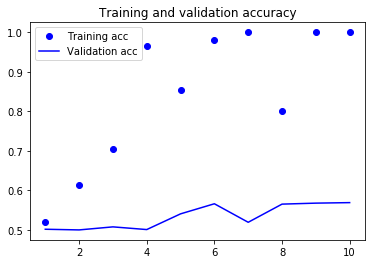

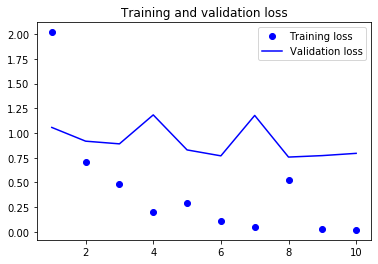

In [32]:
# List 6-15

%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [33]:
# List 6-16

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 3ms/sample - loss: 0.6941 - acc: 0.5750 - val_loss: 0.6938 - val_acc: 0.5039
Epoch 2/10
200/200 [==============================] - 0s 2ms

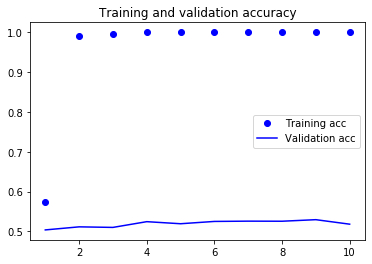

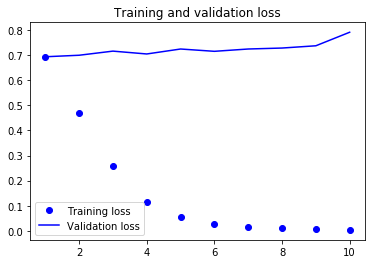

In [34]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [35]:
# List 6-17

# imdb_dir = '/home/takao/Documents/dev/jupyter/DL-By-Python-Keras/6-aclImdb'

test_dir = os.path.join(imdb_dir, 'test')
labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            with open(os.path.join(dir_name, fname)) as f:
                texts.append(f.read())
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
                
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=max_len)
y_test = np.asarray(labels)

In [36]:
# List 6-18

model.load_weights('6-pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 1s 38us/sample - loss: 0.8142 - acc: 0.5572


[0.8142175378799439, 0.5572]